<a href="https://colab.research.google.com/github/abubakrsiddq/ImageDehazing/blob/main/Datasets/generateDataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import PIL
import numpy as np
import matplotlib.pyplot as plt
import glob

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
clear_path_list=glob.glob('/content/drive/MyDrive/kitti/gt/*.png')
depth_path_list=glob.glob('/content/drive/MyDrive/kitti/depth_map/*.png')
clear_path_list.sort()
depth_path_list.sort()

In [4]:
airlight=0.76
beta_param=3.912

In [5]:
A=np.zeros((1,1,3))
A[0,0,:]=airlight;


In [6]:
l=[50]
visual_range=np.array(l,dtype=float)/1000
#Rgb=PIL.Image.open('/content/drive/MyDrive/gen_test/orig0.png')
#depth_map=PIL.Image.open('/content/drive/MyDrive/gen_test/depth0.png')

In [10]:
def rescale_img(Rgb,depth_map):
  I0=np.asarray(Rgb,dtype=float);
  I0=(I0-I0.min())/(I0.max()-I0.min())
  depth=np.asarray(depth_map,dtype=float);
  depth=(depth-depth.min())/(depth.max()-depth.min())
  d=depth/256;
  return I0,d
  
def srgb2lrgb(I0):
  I=np.power((I0+0.055)/1.055,2.4)
  #I=np.where(I0<=0.04045,I0/12.92,I)
  I[I0<=0.04045] = I0[I0<=0.04045]/12.92;
  return I

def lrgb2srgb(I1):
  I2=np.zeros_like(I1);
  for k in range(0,3):
    temp=I1[:,:,k]
    I2[:,:,k] = 12.92*temp*(temp<=0.0031308)+(1.055*np.power(temp,(1/2.4))-0.055)*(temp>0.0031308);
  return I2

In [11]:
for i in range(len(clear_path_list)):
  rgb=PIL.Image.open(clear_path_list[i])
  depth_map=PIL.Image.open(depth_path_list[i])
  (I0,d)=rescale_img(rgb,depth_map)
  for VR in visual_range:
    

    I=srgb2lrgb(I0)
    d[d==0] = 2*VR;
    beta = [beta_param/VR,beta_param/VR,beta_param/VR];
    beta = np.reshape(beta,(1,1,3));
    transmission = np.exp(-beta*np.expand_dims(d,axis=-1));
    #print(transmission.shape)
    Ic = transmission*I+(1-transmission)*A;
    I2 = lrgb2srgb(Ic);
    save_hazy='/content/drive/MyDrive/gen_test/'+clear_path_list[i].split('/')[-1].split('.')[0]+'_'+str(VR)+'_'+str(airlight)+'.png'
    plt.imsave(save_hazy,I2)
  if i==3:
    break

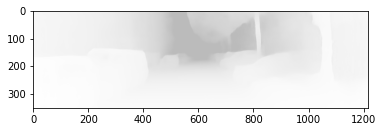

In [12]:
plt.imshow(transmission)

In [13]:
clear_path_list[i].split('/')[-1].split('.')[0]+'_'+str(VR)+'_'+str(airlight)+'.png'

'0000000003_0.05_0.76.png'

In [14]:
I[88,341,0]

1.0

In [15]:
mask

NameError: ignored

In [ ]:
I[I0<=0.04045] = I0[I0<=0.04045]/12.92;

In [ ]:
j=np.array([[1,3,5,2,8,7],[1,3,5,2,8,7]])

In [ ]:
j[j<3]

array([1, 2, 1, 2])

In [ ]:
np.where(I0<0.045)[2].shape

(9147,)

In [ ]:
I0[0,75,2]

0.00784313725490196

In [ ]:
np.where(I0<0.04,I0/12.92,I)

array([[[1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.00151763],
        [0.        , 0.        , 0.        ]],

       [[1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       [[1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       ...,

       [[1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1

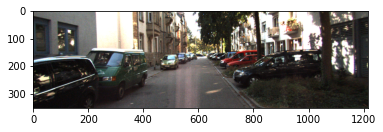

In [49]:
plt.imshow(I0)

In [16]:
import scipy
import skimage
from skimage.color import rgb2gray
import numpy as np
#from pypardiso import spsolve
from scipy.sparse.linalg import spsolve 
from PIL import Image

#
# fill_depth_colorization.m
# Preprocesses the kinect depth image using a gray scale version of the
# RGB image as a weighting for the smoothing. This code is a slight
# adaptation of Anat Levin's colorization code:
#
# See: www.cs.huji.ac.il/~yweiss/Colorization/
#
# Args:
#  imgRgb - HxWx3 matrix, the rgb image for the current frame. This must
#      be between 0 and 1.
#  imgDepth - HxW matrix, the depth image for the current frame in
#       absolute (meters) space.
#  alpha - a penalty value between 0 and 1 for the current depth values.

def fill_depth_colorization(imgRgb=None, imgDepthInput=None, alpha=1):
	imgIsNoise = imgDepthInput == 0
	maxImgAbsDepth = np.max(imgDepthInput)
	imgDepth = imgDepthInput / maxImgAbsDepth
	imgDepth[imgDepth > 1] = 1
	(H, W) = imgDepth.shape
	numPix = H * W
	indsM = np.arange(numPix).reshape((W, H)).transpose()
	knownValMask = (imgIsNoise == False).astype(int)
	grayImg = rgb2gray(imgRgb)
	winRad = 1
	len_ = 0
	absImgNdx = 0
	len_window = (2 * winRad + 1) ** 2
	len_zeros = numPix * len_window

	cols = np.zeros(len_zeros) - 1
	rows = np.zeros(len_zeros) - 1
	vals = np.zeros(len_zeros) - 1
	gvals = np.zeros(len_window) - 1

	for j in range(W):
		for i in range(H):
			nWin = 0
			for ii in range(max(0, i - winRad), min(i + winRad + 1, H)):
				for jj in range(max(0, j - winRad), min(j + winRad + 1, W)):
					if ii == i and jj == j:
						continue

					rows[len_] = absImgNdx
					cols[len_] = indsM[ii, jj]
					gvals[nWin] = grayImg[ii, jj]

					len_ = len_ + 1
					nWin = nWin + 1

			curVal = grayImg[i, j]
			gvals[nWin] = curVal
			c_var = np.mean((gvals[:nWin + 1] - np.mean(gvals[:nWin+ 1])) ** 2)

			csig = c_var * 0.6
			mgv = np.min((gvals[:nWin] - curVal) ** 2)
			if csig < -mgv / np.log(0.01):
				csig = -mgv / np.log(0.01)

			if csig < 2e-06:
				csig = 2e-06

			gvals[:nWin] = np.exp(-(gvals[:nWin] - curVal) ** 2 / csig)
			gvals[:nWin] = gvals[:nWin] / sum(gvals[:nWin])
			vals[len_ - nWin:len_] = -gvals[:nWin]

	  		# Now the self-reference (along the diagonal).
			rows[len_] = absImgNdx
			cols[len_] = absImgNdx
			vals[len_] = 1  # sum(gvals(1:nWin))

			len_ = len_ + 1
			absImgNdx = absImgNdx + 1

	vals = vals[:len_]
	cols = cols[:len_]
	rows = rows[:len_]
	A = scipy.sparse.csr_matrix((vals, (rows, cols)), (numPix, numPix))

	rows = np.arange(0, numPix)
	cols = np.arange(0, numPix)
	vals = (knownValMask * alpha).transpose().reshape(numPix)
	G = scipy.sparse.csr_matrix((vals, (rows, cols)), (numPix, numPix))

	A = A + G
	b = np.multiply(vals.reshape(numPix), imgDepth.flatten('F'))

	#print ('Solving system..')

	new_vals = spsolve(A, b)
	new_vals = np.reshape(new_vals, (H, W), 'F')

	#print ('Done.')

	denoisedDepthImg = new_vals * maxImgAbsDepth
    
	output = denoisedDepthImg.reshape((H, W)).astype('float32')

	output = np.multiply(output, (1-knownValMask)) + imgDepthInput
    
	return output

In [20]:
a=fill_depth_colorization(I0,dep)

In [18]:
dep=PIL.Image.open('0000000003.png')

In [19]:
dep=np.asarray(dep)

In [57]:
dep[dep>0]

array([1719, 1720, 1716, ..., 1336, 1340, 1331], dtype=int32)

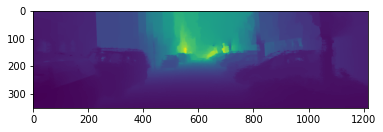

In [21]:
plt.imshow(a)